# Predicting Dowe Jones Stock Values Using News Headlines

### Motivation : 
Predictions in quantitative finance are typically based solely on historical data. Here I see if I can add predicitive power to a model incorporating news headlines into the data, and also sentiment analysis. 

### Summary : 

I use a dataset from Kaggle with about 74,000 headlines from 2008-06-08 to 2016-07-01, and historical data of Dowe Jones Industrial Average within the same time frame.  To keep it simple, we only try to predict the *Adjusted Closing Price* from each day, and build three different models for comparison : 
<br>
- Purely Historical Based
- Historical + News Headlines (NLP)
- Historical + News Headlines + Sentiment Analysis of headlines
<br>
The model itself is a Deep Neural Network with the following topography : 

**Input: ** Closing price of the past 30 days (+ corresponding headlines) (+ sentiment analysis)<br>
**First Layer : ** 500 Nodes with SoftPlus Activation<br>
**Second Layer :** 300 Nodes with SoftPlus Activation<br>
**Third Layer :** 200 Nodes with SoftPlus Activation<br>
**Fourth Layer :** 100 Nodes with SoftPlus Activation<br>
**Ouput :** Adjusted Closing Price for a given day. <br>
<br>

Text is vectorized using Bag of Words approach. 

### Results : 

First glance suggests that simply adding text to the results actually reduces the predictions accuracy.  This could be due to too many features being incorporated, and adding "chaos" to the system.  But, included with sentiment analysis gives slightly more accurate predictions.  Furthers tests need to be implemented to check if there is the difference is statistically significant. 

# The Code

In [2]:
# Import Libraries
# Basic
import pandas as pd
import numpy as np
import string
from datetime import datetime, timedelta

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# NLP 
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import TextBlob

# Model Building
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import r2_score


## Import the Data

In [3]:
# Import data as Pandas Dataframe
news = pd.read_csv('RedditNews.csv')
stocks = pd.read_csv('DJIA_table.csv')

# Rename Columns
news.columns = [c.strip().lower().replace(' ', '_') for c in news.columns]
stocks.columns = [c.strip().lower().replace(' ', '_') for c in stocks.columns]

# Convert date string to datetime object
news.date   = pd.to_datetime(news.date)
stocks.date = pd.to_datetime(stocks.date)

# Some strings were supposed to be represented as bytes, but it just adds a b' to the string.  We replace that
# with nothing. 
news.news = news.news.apply(lambda x: x.replace("b'", ""))
news.news = news.news.apply(lambda x: x.replace('b"', ''))

# For this project, I am only using adjusted closing prices so I will drop the other values in teh stocks data.
stocks = stocks[['date', 'adj_close']]

## Sentiment Analysis

Using the TextBlob library, we can associate each work in a string with a general sentiment or polarity (positive or negative (-1, 1), and a subjectivity value (-1, 1).  That is, "I love cheese" would be a subjective statement.  To simplify the process, we define two functions : one that will return the subjectivity, and one that will return the polarity. 

In [4]:
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

In [5]:
news['polarity'] = news.news.apply(get_polarity)
news['subjectivity'] = news.news.apply(get_subjectivity)

In [6]:
news.head()

,date,news,polarity,subjectivity
0,2016-07-01,A 117-year-old woman in Mexico City finally re...,-0.066667,0.366667
1,2016-07-01,IMF chief backs Athens as permanent Olympic host,0.000000,0.000000
2,2016-07-01,"The president of France says if Brexit won, so...",0.000000,0.000000
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...,0.111111,0.388889
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...,0.000000,0.000000


## Start Cleaning the Text.  

Now that we have extracted polarity and subjectivity from the text, we can start cleaning it.  For this we use the following function which removes punctuation, stopwords, numbers, etc...

In [7]:
# Text Preprocessor : 
def process_text(text, stemmer, stop_words):
    
    # Make all characters in text lower case
    text = text.strip().lower()
    
    # Remove Punctuation
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = text.translate(str.maketrans('', '', string.digits))      # remove numbers
    
    # Split text into all its different words, and process the words individually
    new_text = []
    for w in text.split():
        w = w.strip() # make sure there a no extra white spaces
        if w in stop_words:
            # Go to next iteration if w is a stop word
            continue
        
        else:
            # Get rid of any left over apostrophes
            w.replace("'", " ")
        
            # Stem words and append new word to a list
            w = stemmer.stem(w)
            new_text.append(w)
    
    # Return processed words as one long string
    return ' '.join(new_text)

In [8]:
news.news = news.news.apply(lambda x : process_text(x, PorterStemmer(), stopwords.words('english')))

In [9]:
news.head()

,date,news,polarity,subjectivity
0,2016-07-01,yearold woman mexico citi final receiv birth c...,-0.066667,0.366667
1,2016-07-01,imf chief back athen perman olymp host,0.000000,0.000000
2,2016-07-01,presid franc say brexit donald trump,0.000000,0.000000
3,2016-07-01,british man must give polic hour notic sex thr...,0.111111,0.388889
4,2016-07-01,nobel laureat urg greenpeac stop oppos gmo,0.000000,0.000000


## Pooling By Date

Because there are multiple articles for each day in this data set, we want to start bringing them together.  For this, we create a `data` dataframe which will hold all of our data, including stock values, dates, a concatenation of headlines from each day, the sum of the polarity for that day, and the sum of the subjectiveness for that day. 

In [10]:
# Do some groupby things to get the joined text, and sums of polarity for specific dates (and subjectivity)
g1 = pd.DataFrame(news.groupby('date')['news'].apply(lambda x: ' '.join(x)))
g2 = pd.DataFrame(news.groupby('date')['polarity'].sum())
g3 = pd.DataFrame(news.groupby('date')['subjectivity'].sum())

data = pd.DataFrame()
data['date'] = g1.index
data['news'] = g1['news'].values
data['polarity'] = g2['polarity'].values
data['subjectivity'] = g3['subjectivity'].values

data.head()

,date,news,polarity,subjectivity
0,2008-06-08,nim chimpski tragedi chimp thought boy prove h...,-0.822298,6.321553
1,2008-06-09,unit state quit human right council pentagon b...,0.653896,5.084416
2,2008-06-10,oil shortag myth say industri insid israel lau...,-0.727652,3.006439
3,2008-06-11,bbc uncov lost iraq billion war crimin georg w...,-0.362500,6.212500
4,2008-06-12,us attack pakistan last night pakistan furi de...,0.915278,7.612500


With this in hand, we still will merge it with the stocks data to have everything in one place. 

In [11]:
# Merge stocks data with news data, since we are targeting values in the stocks data, we will only keep
# dates that are present in that one (right merge)
data = data.merge(stocks, on='date', how='right')

In [12]:
data.head()

,date,news,polarity,subjectivity,adj_close
0,2008-08-08,georgia down two russian warplan countri move ...,-1.171873,4.290272,11734.320312
1,2008-08-11,wont america nato help us wont help us help ir...,1.175505,4.604091,11782.349609
2,2008-08-12,rememb ador yearold sang open ceremoni fake ru...,-0.986652,9.097799,11642.469727
3,2008-08-13,us refus israel weapon attack iran report pres...,0.014418,3.896825,11532.959961
4,2008-08-14,expert admit legalis drug war south osetia pic...,1.266396,7.060714,11615.929688


## Prepping as Time Series Data

Because predictions are basesd on previous values (hence the time series), we need to decide how far back we are going to be looking in terms of news headlines.  Since stocks are a volatile system, we don't need to look too far back, and we have access to historical data so we will choose ** 3 days prior **.  For this we concatenate the strings of a certain date with the strings from the 3 previous days.  We do not want to lose the information from the sentiment analysis from each day, so we will be adding 3 columns to the dataframe.  But let's start by pooling the news from T-3 days.   

In [13]:
# Define function to pool N-dates. 
def pool_Ndays(N, date, df):
    # Get text from t previous days before; 
    # append everything (including current day) as one long string
    # re
    
    # ensure this is a copy not a view of the DataFrame
    df = df.copy()
    
    text = df[(df.date <= date) & (df.date >= (date - timedelta(N)))].news.values
    text = " ".join(text)
    
    return text

In [14]:
# Pool 90 Days of headlines, and replace the text in the news column with the pooled text
data.news = data.date.apply(lambda x: pool_Ndays(3, x, data))

Now that we have pooled the text, we need to get the "historical" sentiment for each row. (i.e the sentiment over the past few days). For this we define a function as well : 

In [15]:
data.head()

,date,news,polarity,subjectivity,adj_close
0,2008-08-08,georgia down two russian warplan countri move ...,-1.171873,4.290272,11734.320312
1,2008-08-11,georgia down two russian warplan countri move ...,1.175505,4.604091,11782.349609
2,2008-08-12,wont america nato help us wont help us help ir...,-0.986652,9.097799,11642.469727
3,2008-08-13,wont america nato help us wont help us help ir...,0.014418,3.896825,11532.959961
4,2008-08-14,wont america nato help us wont help us help ir...,1.266396,7.060714,11615.929688


In [16]:
def get_passed_value(N, date, df, value='adj_close'):
    # REturn a value in dataframe at date - N days. 
    # If none present, return is based on queried value : 
    
    # adj_close : latest available value, or None if unavailable
    # polarity  : 0
    # subjectivity : 0
    
    # N - number of days back to get the polarity of that day
    # date - the current date (or date in row)
    # df - the whole dataframe
    
    # ensure we are using a copy of the dataframe
    df = df.copy()
    
    v = df[value][df.date == (date - timedelta(N))].values
    
    # Return desired date (if it exists)
    if len(v) == 1:
        return v[0]
    
    # If it doesn't exist : 
    else:
        
        # If we are looking for adj_close, return latest available value, or None if there are none before
        if value == 'adj_close':
            v = np.sort(df.adj_close[df.date < date].values)
            
            if len(v) == 0:
                return None
            
            else:
                return v[-1]
        
        # If we are looking for polarity or subjectivity, return 0
        else:
            return 0
    

In [17]:
for i in range(3):
    N = i + 1
    p_label = 'p_minus' + str(N)
    s_label = 's_minus' + str(N)
    a_label = 'a_minus' + str(N)
    
    data[p_label] = data.date.apply(lambda x: get_passed_value(N, x, data, value='polarity'))
    data[s_label] = data.date.apply(lambda x: get_passed_value(N, x, data, value='subjectivity'))
    data[a_label] = data.date.apply(lambda x: get_passed_value(N, x, data, value='adj_close'))

data.head()

,date,news,polarity,subjectivity,adj_close,p_minus1,s_minus1,a_minus1,p_minus2,s_minus2,a_minus2,p_minus3,s_minus3,a_minus3
0,2008-08-08,georgia down two russian warplan countri move ...,-1.171873,4.290272,11734.320312,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN
1,2008-08-11,georgia down two russian warplan countri move ...,1.175505,4.604091,11782.349609,0.000000,0.000000,11734.320312,0.000000,0.000000,11734.320312,-1.171873,4.290272,11734.320312
2,2008-08-12,wont america nato help us wont help us help ir...,-0.986652,9.097799,11642.469727,1.175505,4.604091,11782.349609,0.000000,0.000000,11782.349609,0.000000,0.000000,11782.349609
3,2008-08-13,wont america nato help us wont help us help ir...,0.014418,3.896825,11532.959961,-0.986652,9.097799,11642.469727,1.175505,4.604091,11782.349609,0.000000,0.000000,11782.349609
4,2008-08-14,wont america nato help us wont help us help ir...,1.266396,7.060714,11615.929688,0.014418,3.896825,11532.959961,-0.986652,9.097799,11642.469727,1.175505,4.604091,11782.349609


Now we have everything set up for time series analysis, but before making models, we need to vectorize the text.  But before that!  Let's save this dataframe so that we can access it more easily later on. 

In [ ]:
# Save Processed data so far. 
data.to_csv('data_pre_vectorization.csv')

## Train Test Split

Because we are going to be vectorizing, we  have to split our data into a training and testing set.  However, we can not randomly split the data, since the idea is to see if past data can predict the future ones.  We are going to have to split in a chronological basis.  For this, **I choose to use the last 30 days of our data as the test set**, and everything else as the training.   But for the sake of generality, let's define a function to get an arbitrary number of dates:

In [18]:
def split_by_date(df, training_days = 100):
    # Do a train test split on the data and, keep the date 
    # so that we can reorder for future use. 
    
    date = df.date.max() - timedelta(days=training_days)
    
    training = df[df.date <= date]
    testing  = df[df.date > date]
    
    return [training, testing]


In [48]:
# Train Test split the data (chronologically)
train, test = split_by_date(data, training_days=365)

In [49]:
test.shape

(252, 14)

## Filling In Null Values
Because our previous function returned null values when there were no available adj_close values, we need to define an Imputer to fill those in.  We take a look at the distribution of those values to get an idea, of which strategy we should be using : 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5050674ef0>]],
      dtype=object)

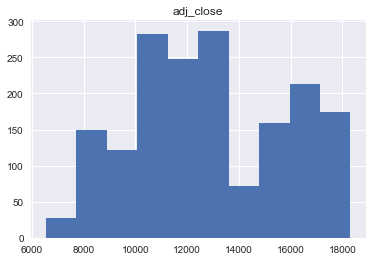

In [50]:
train.hist('adj_close')

There seem to be two different types of distributions, one centered around 18000, and one around 12000.  This may have a time-dependent factor, so we should take a lookt at how that value evolves over time. 

In [51]:
test.shape

(252, 14)

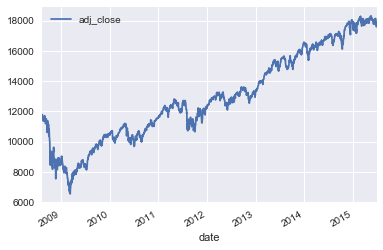

In [52]:
train.plot(x='date', y='adj_close')

There doesn't seem to be two distinctive groups from the time-plot, but we can see that the `adj_close` price is rising with time.  From this we can **make a decision** : Imputed value is based on whether or not the date is prior to 2014.  To check this : 

There is a little overlap, but that should do the trick.  We now need to calculate the mean for values in each of those time periods. 

In [53]:
mean_pre  = data.adj_close[data.date < pd.to_datetime('2013-01-01')].mean()
mean_post = data.adj_close[data.date >= pd.to_datetime('2013-01-01')].mean()

In the end, the way we got `a_minusN` only returns null values for the first row in the data. So we'll just impute them manually. 

In [54]:
train.fillna(mean_pre, inplace=True);

/home/thomas/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2852: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


## Text Vectorization : Bag of Words

For this I am going to keep it simple, and use a word count, or bag of words. 

In [55]:
# Define the countvectorizer :
Vectorizer = CountVectorizer(min_df=0.1)
Vectorizer.fit(train.news)

_ = Vectorizer.transform(train.news).todense()
vectorized_text_training = pd.DataFrame(_, columns = Vectorizer.get_feature_names()) 

vectorized_text_training.head()

,abandon,abl,abort,abus,accept,access,accid,accord,account,accus,...,yet,york,young,your,youth,youtub,yr,zealand,zimbabw,zone
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,1,0,0


With the vectorized text, we can drop the news column, and replace wiht all the ones that were created. 

In [56]:
train_vectorized = pd.concat([vectorized_text_training, train], axis=1)
train_vectorized.drop('news', inplace=True, axis=1)
train_vectorized.head()

,abandon,abl,abort,abus,accept,access,accid,accord,account,accus,...,adj_close,p_minus1,s_minus1,a_minus1,p_minus2,s_minus2,a_minus2,p_minus3,s_minus3,a_minus3
0,0,0,0,0,0,0,0,0,0,0,...,11734.320312,0.000000,0.000000,10988.595578,0.000000,0.000000,10988.595578,0.000000,0.000000,10988.595578
1,1,0,0,0,0,0,0,0,0,0,...,11782.349609,0.000000,0.000000,11734.320312,0.000000,0.000000,11734.320312,-1.171873,4.290272,11734.320312
2,1,0,0,0,0,0,0,0,0,1,...,11642.469727,1.175505,4.604091,11782.349609,0.000000,0.000000,11782.349609,0.000000,0.000000,11782.349609
3,1,0,0,0,0,0,0,0,0,2,...,11532.959961,-0.986652,9.097799,11642.469727,1.175505,4.604091,11782.349609,0.000000,0.000000,11782.349609
4,1,0,0,0,0,0,0,0,0,3,...,11615.929688,0.014418,3.896825,11532.959961,-0.986652,9.097799,11642.469727,1.175505,4.604091,11782.349609


We do this for our test set as well :

In [57]:
_ = Vectorizer.transform(test.news).todense()
vectorized_text_testing = pd.DataFrame(_, columns = Vectorizer.get_feature_names()) 
vectorized_text_testing.head()

,abandon,abl,abort,abus,accept,access,accid,accord,account,accus,...,yet,york,young,your,youth,youtub,yr,zealand,zimbabw,zone
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,1,1,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,1
3,1,0,1,2,1,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,1
4,1,0,1,2,1,0,0,1,0,1,...,0,0,2,0,0,0,0,0,0,1


In [58]:
vectorized_text_testing.shape

(252, 1502)

In [59]:
test.shape

(252, 14)

In [60]:
# Concat the values to keep them in one place 
test.reset_index(drop=True, inplace=True)
test_vectorized = pd.concat([vectorized_text_testing, test], axis=1)
test_vectorized.drop('news', inplace=True, axis=1)
test_vectorized.head()

,abandon,abl,abort,abus,accept,access,accid,accord,account,accus,...,adj_close,p_minus1,s_minus1,a_minus1,p_minus2,s_minus2,a_minus2,p_minus3,s_minus3,a_minus3
0,0,0,0,0,1,0,0,0,0,0,...,17683.580078,0.000000,0.000000,18312.390625,0.000000,0.000000,18312.390625,0.000000,0.000000,18312.390625
1,0,0,0,1,1,0,0,0,0,0,...,17776.910156,-0.155952,5.645754,17683.580078,0.000000,0.000000,18312.390625,0.000000,0.000000,18312.390625
2,1,0,1,1,1,0,0,0,0,0,...,17515.419922,0.072652,7.393712,17776.910156,-0.155952,5.645754,17683.580078,0.000000,0.000000,18312.390625
3,1,0,1,2,1,0,0,0,0,0,...,17548.619141,0.616492,7.478926,17515.419922,0.072652,7.393712,17776.910156,-0.155952,5.645754,17683.580078
4,1,0,1,2,1,0,0,1,0,1,...,17760.410156,2.422247,6.492677,17548.619141,0.616492,7.478926,17515.419922,0.072652,7.393712,17776.910156


## Making the Model.  

Now we are finally able to make a model and see if the news headlines help us predict adjusted closing prices.  Let's split our data into X, and y. I will want to keep the dates for future plotting, so I will carry them around with the y vector. 

In [61]:
train_vectorized.columns = [c if c != 'date' else ('date' + str(i)) for i, c in enumerate(train_vectorized)]
train_vectorized.columns = [c if c != 'date1501' else ('actual_date') for i, c in enumerate(train_vectorized)]
train_vectorized.columns = [c if c != 'date340' else ('date') for i, c in enumerate(train_vectorized)]


In [32]:
y_train = train_vectorized[['adj_close', 'actual_date']]
X_train = train_vectorized.drop(['adj_close', 'actual_date'], axis=1)

In [62]:
X_train.head()

,abandon,abl,abort,abus,accept,access,accid,accord,account,accus,...,subjectivity,p_minus1,s_minus1,a_minus1,p_minus2,s_minus2,a_minus2,p_minus3,s_minus3,a_minus3
0,0,0,0,0,0,0,0,0,0,0,...,4.290272,0.000000,0.000000,10988.595578,0.000000,0.000000,10988.595578,0.000000,0.000000,10988.595578
1,1,0,0,0,0,0,0,0,0,0,...,4.604091,0.000000,0.000000,11734.320312,0.000000,0.000000,11734.320312,-1.171873,4.290272,11734.320312
2,1,0,0,0,0,0,0,0,0,1,...,9.097799,1.175505,4.604091,11782.349609,0.000000,0.000000,11782.349609,0.000000,0.000000,11782.349609
3,1,0,0,0,0,0,0,0,0,2,...,3.896825,-0.986652,9.097799,11642.469727,1.175505,4.604091,11782.349609,0.000000,0.000000,11782.349609
4,1,0,0,0,0,0,0,0,0,3,...,7.060714,0.014418,3.896825,11532.959961,-0.986652,9.097799,11642.469727,1.175505,4.604091,11782.349609


In [63]:
y_train.head()

,adj_close,actual_date,predictions
0,11734.320312,2008-08-08,10575.130859
1,11782.349609,2008-08-11,11378.806641
2,11642.469727,2008-08-12,11381.015625
3,11532.959961,2008-08-13,11408.574219
4,11615.929688,2008-08-14,11444.098633


Do the same for the testing set : 

In [64]:
test_vectorized.columns = [c if c != 'date' else ('date' + str(i)) for i, c in enumerate(test_vectorized)]
test_vectorized.columns = [c if c != 'date1501' else ('actual_date') for i, c in enumerate(test_vectorized)]
test_vectorized.columns = [c if c != 'date340' else ('date') for i, c in enumerate(test_vectorized)]

In [65]:
y_test = test_vectorized[['adj_close', 'actual_date']]
X_test = test_vectorized.drop(['adj_close', 'actual_date'], axis=1)

In [66]:
y_test.head()

,adj_close,actual_date
0,17683.580078,2015-07-06
1,17776.910156,2015-07-07
2,17515.419922,2015-07-08
3,17548.619141,2015-07-09
4,17760.410156,2015-07-10


In [68]:
# Create the ANN (staying basic right now)
activation = tf.nn.softplus #[tf.nn.tanh, tf.nn.relu, tf.nn.relu, tf.nn.relu, tf.nn.relu]

feature_cols = tf.contrib.learn.infer_real_valued_columns_from_input(X_train)
dnn_reg = tf.contrib.learn.DNNRegressor(hidden_units=[500, 300, 200, 100],
                                        feature_columns=feature_cols,
                                       activation_fn = activation)
dnn_reg = tf.contrib.learn.SKCompat(dnn_reg)
dnn_reg.fit(X_train, y_train['adj_close'], batch_size=100, steps=1000)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f50503e5550>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmpsjh3mia1'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpsjh3mia1/model.ckpt.
INFO:tensorflow:loss = 204595040.0, step = 1
INFO:tensorflow:global_step/sec: 23.0795
INFO:tensorflow:loss = 337029.44, step = 101 (4.335 sec)
INFO:tensorflow:global_step/sec: 23.1963
INFO:tensorflow:lo

SKCompat()

In [69]:
y_train['predictions'] = dnn_reg.predict(X_train)['scores']
y_test['predictions'] = dnn_reg.predict(X_test)['scores']

INFO:tensorflow:Restoring parameters from /tmp/tmpsjh3mia1/model.ckpt-1000
INFO:tensorflow:Restoring parameters from /tmp/tmpsjh3mia1/model.ckpt-1000


/home/thomas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [70]:
def plot_results(train, test, title=None, dateline=False, ndays=30, predictions='predictions'):

    
    r2_train = round(r2_score(train.adj_close, train[predictions]), 3)
    r2_test  = round(r2_score(test.adj_close, test[predictions]), 3)
    
    train_title = 'Training, R2 = {}'.format(str(r2_train))
    test_title = 'Test, R2 = {}'.format(str(r2_test))
    
    top_xaxis = 'Actual Adjusted Closing Price ($)'
    top_yaxis = 'Predicted Adjusted Closing Price ($)'
    bottom_xaxis = 'Date'
    bottom_axis  = 'Adjusted Closing Price ($)'
    
    title_size = 18
    
    f, [(ax1, ax2), (ax3, ax4)] = plt.subplots(nrows=2, ncols=2, figsize=(15,12))

    if title!=None:
        f.suptitle(title, size=title_size+1)

    # Training Plot
    ax1.scatter(x=train['adj_close'], y=train[predictions])
    ax1.set_xlabel(top_xaxis)
    ax1.set_ylabel(top_yaxis)
    ax1.set_title(train_title, fontsize=title_size)
    
    train.plot(x='actual_date', y='adj_close', ax=ax3, label='actual')
    train.plot(x='actual_date', y=predictions, ax=ax3, alpha=0.5, label='predicted')
    ax3.legend()
    
    adj_min = 5000
    adj_max = 22500
    
    ax1.set_xlim(adj_min, adj_max)
    ax1.set_ylim(adj_min, adj_max)
    ax2.set_xlim(adj_min, adj_max)
    ax2.set_ylim(adj_min, adj_max)
    
    # Testing Plot
    ax2.scatter(x=test['adj_close'], y=test[predictions])
    ax2.set_xlabel(top_xaxis)
    ax2.set_ylabel(top_yaxis)
    ax2.set_title(test_title, fontsize=title_size)

    test.plot(x='actual_date', y='adj_close', ax=ax4, label='actual')
    test.plot(x='actual_date', y=predictions, ax=ax4, alpha=0.5, label='predicted')
    
    ax3.set_ylim(adj_min, adj_max)
    ax4.set_ylim(adj_min, adj_max)
    
    line = np.arange(adj_min, adj_max, 1)
    ax1.plot(line, line, 'k--', alpha=0.7)
    ax2.plot(line, line, 'k--', alpha=0.7)
    
    if dateline == True:
        date = test.actual_date.min() + timedelta(days=ndays)
        line_x = [date, date]
        line_y = [adj_min, adj_max]
        ax4.plot(line_x, line_y, 'k--', alpha=0.7, label='date line')
        
    ax3.legend()
    ax4.legend()
        
    pass

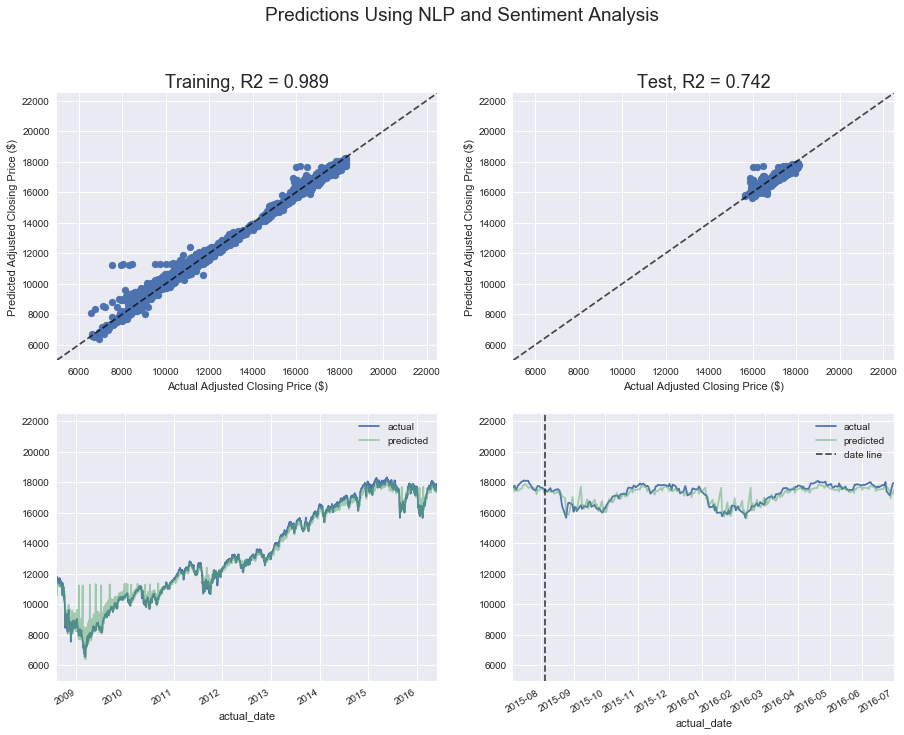

In [72]:
plot_results(y_train, y_test, dateline=True, title='Predictions Using NLP and Sentiment Analysis')

## Without NLP :

Now that we have done the chunk of it, lets see what we wwould have predicted with just historical data. 

In [73]:
X_train_noNLP = X_train[['a_minus1', 'a_minus2', 'a_minus3']]
X_test_noNLP = X_test[['a_minus1', 'a_minus2', 'a_minus3']]


tf.reset_default_graph()
# Create the ANN (staying basic right now)
activation = tf.nn.softplus #[tf.nn.tanh, tf.nn.relu, tf.nn.relu, tf.nn.relu, tf.nn.relu]

feature_cols = tf.contrib.learn.infer_real_valued_columns_from_input(X_train_noNLP)
dnn_reg = tf.contrib.learn.DNNRegressor(hidden_units=[500, 300, 200, 100],
                                        feature_columns=feature_cols,
                                       activation_fn = activation)
dnn_reg = tf.contrib.learn.SKCompat(dnn_reg)
dnn_reg.fit(X_train_noNLP, y_train['adj_close'], batch_size=100, steps=1000)

y_train['predictions_noNLP'] = dnn_reg.predict(X_train_noNLP)['scores']
y_test['predictions_noNLP'] = dnn_reg.predict(X_test_noNLP)['scores']

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f503a3dd4a8>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmpel24_5r3'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpel24_5r3/model.ckpt.
INFO:tensorflow:loss = 203343780.0, step = 1
INFO:tensorflow:global_step/sec: 47.0186
INFO:tensorflow:loss = 302438.6, step = 101 (2.128 sec)
INFO:tensorflow:global_step/sec: 44.6829
INFO:tensorflow:los

/home/thomas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


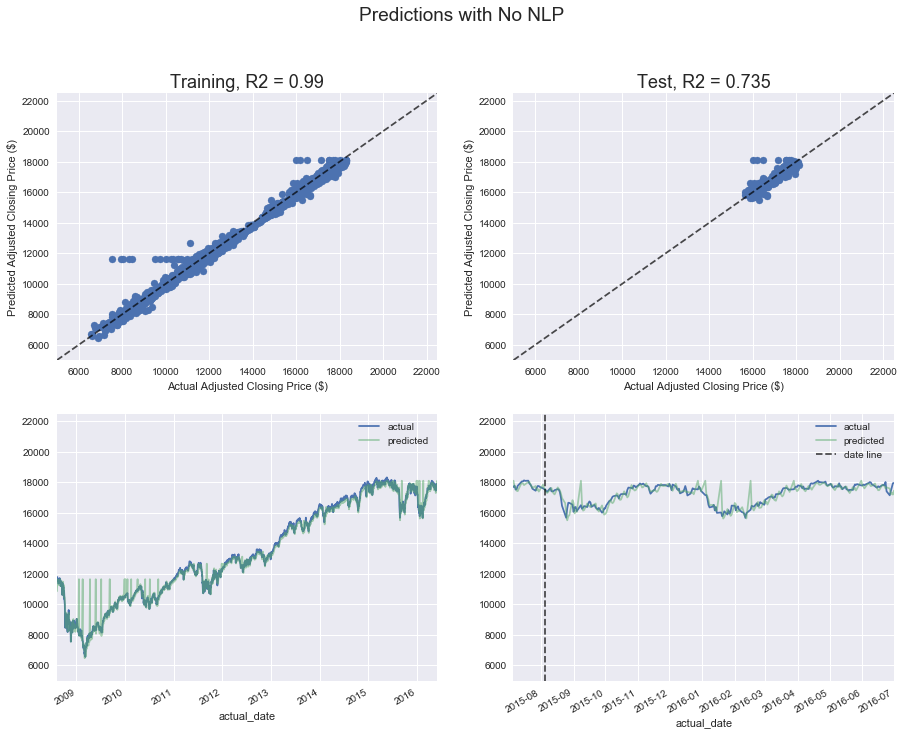

In [83]:
plot_results(y_train, y_test, dateline=True, title='Predictions with No NLP', predictions='predictions_noNLP')

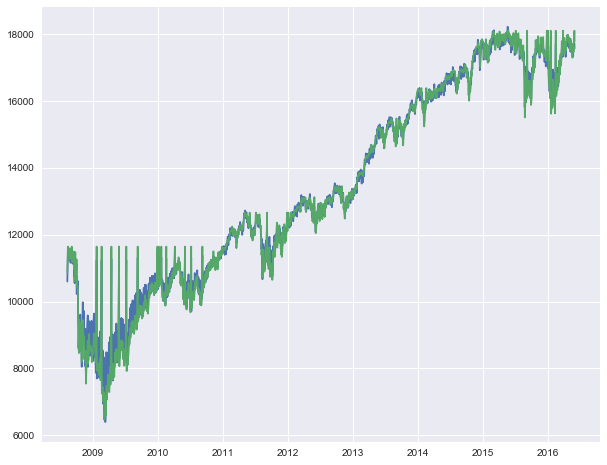

In [86]:
f, ax  = plt.subplots(figsize=(10, 8))

ax.plot(y_train['actual_date'], y_train['predictions'], label='with NLP')
ax.plot(y_train['actual_date'], y_train['predictions_noNLP'], label='no NLP')

# NLP ONLY

In [82]:
for c in X_train.co

p_minus1
s_minus1
a_minus1
p_minus2
s_minus2
a_minus2
p_minus3
s_minus3
a_minus3


In [93]:
print(X_train.shape, y_train.shape)

(1967, 1512) (1967, 4)


In [95]:
print(X_test.shape, y_test.shape)

(252, 1512) (252, 4)


In [87]:
print('p_minus1')

p_minus1


In [88]:
omitted

['p_minus1', 'p_minus2', 'p_minus3', 's_minus1', 's_minus2', 's_minus3']

In [96]:
omitted = ['p_minus' +str(i+1) for i in range(3)]
omitted.extend(['s_minus' + str(i+1) for i in range(3)])
print(omitted)

X_train_noSent = X_train[[c for c in X_train.columns if c not in omitted]].copy()
X_test_noSent   = X_test[[c for c in X_test.columns if c not in omitted]].copy()

tf.reset_default_graph()
# Create the ANN (staying basic right now)
activation = tf.nn.softplus #[tf.nn.tanh, tf.nn.relu, tf.nn.relu, tf.nn.relu, tf.nn.relu]

feature_cols = tf.contrib.learn.infer_real_valued_columns_from_input(X_train_noSent)
dnn_reg = tf.contrib.learn.DNNRegressor(hidden_units=[500, 300, 200, 100],
                                        feature_columns=feature_cols,
                                       activation_fn = activation)
dnn_reg = tf.contrib.learn.SKCompat(dnn_reg)
dnn_reg.fit(X_train_noSent, y_train['adj_close'], batch_size=100, steps=1000)

y_train['predictions_noSent'] = dnn_reg.predict(X_train_noSent)['scores']
y_test['predictions_noSent'] = dnn_reg.predict(X_test_noSent)['scores']

['p_minus1', 'p_minus2', 'p_minus3', 's_minus1', 's_minus2', 's_minus3']
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5039be28d0>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmpd584ad63'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpd584ad63/model.ckpt.
INFO:tensorflow:loss = 209164530.0, step = 1
INFO:tensorflow:global_step/sec: 18.7914
INFO:tensorflow:loss = 310513.1, step = 101

/home/thomas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


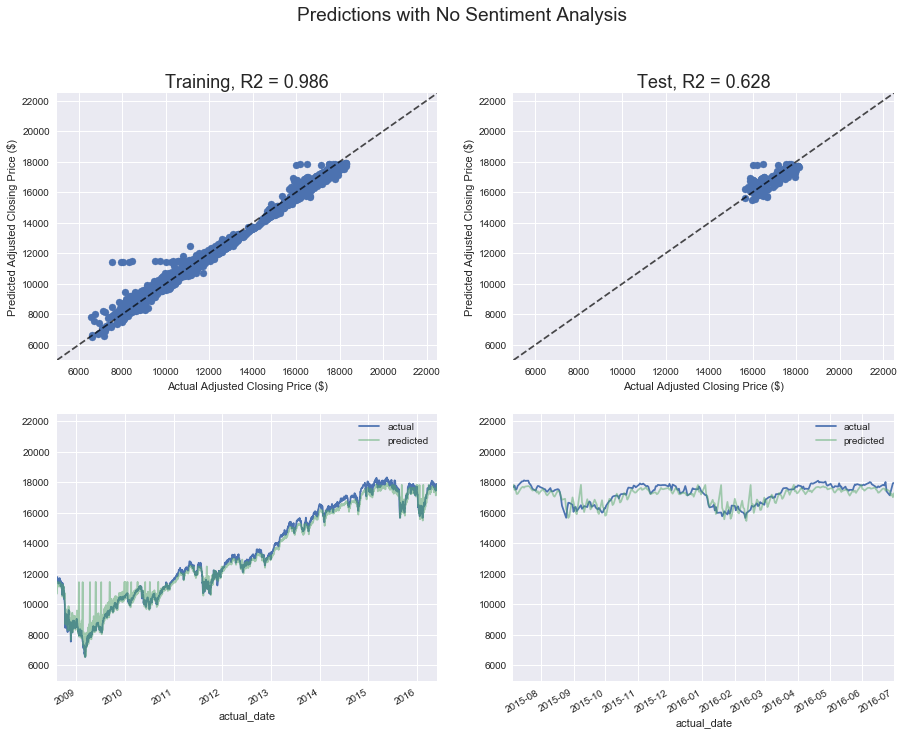

In [97]:
plot_results(y_train, y_test, dateline=False, title='Predictions with No Sentiment Analysis', predictions='predictions_noSent')

Text(0.5,1,'NLP, With Sentiment, R2=0.742')

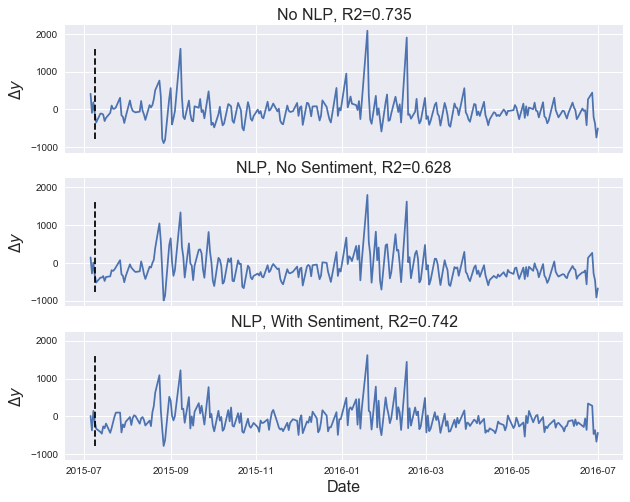

In [123]:
date = y_test.actual_date.min() + timedelta(days=3)

r21 = round(r2_score(y_test.adj_close, y_test.predictions_noNLP), 3)
r22 = round(r2_score(y_test.adj_close, y_test.predictions), 3)
r23 = round(r2_score(y_test.adj_close, y_test.predictions_noSent), 3)


line_x = [date, date]
line_y1 = [min(y_test.predictions - y_test.adj_close), max(y_test.predictions - y_test.adj_close)]


f, [ax1, ax2, ax3] = plt.subplots(figsize=(10,8), nrows=3, sharey=True, sharex=True)
ax1.plot(y_test['actual_date'], y_test['predictions_noNLP'] - y_test['adj_close'])
ax3.plot(y_test['actual_date'], y_test['predictions'] - y_test['adj_close'])
ax2.plot(y_test['actual_date'], y_test['predictions_noSent'] - y_test['adj_close'])

ax1.plot(line_x, line_y1, 'k--')
ax3.plot(line_x, line_y1, 'k--')
ax2.plot(line_x, line_y1, 'k--')

ax1.set_ylabel(r'$\Delta y$', fontsize=15)
ax3.set_ylabel(r'$\Delta y$', fontsize=15)
ax2.set_ylabel(r'$\Delta y$', fontsize=15)
ax3.set_xlabel('Date', fontsize=16)

ax1.set_title('No NLP, R2=' + str(r21), fontsize=16)
ax2.set_title('NLP, No Sentiment, R2=' + str(r23), fontsize=16)
ax3.set_title('NLP, With Sentiment, R2=' + str(r22), fontsize=16)


In [ ]:
plot_results(predictions_30days[0], predictions_30days[1], title='T - 30 days')

## Notes on this : 

All this seems to have worked quite well, but there is an issue.  Because we are splitting on random instances/dates, we are effectively modeling at the random states. To get an idea if our model works, we should should split it time-wise.  Meaning we use a train-test split based on the date, so that we see if we can predict future values. 

In [ ]:
def split_by_date(df, seed=42):
    # Do a train test split on the data and, keep the date 
    # so that we can reorder for future use. 
    
    date = df.date.max() - timedelta(days=90)
    
    training = df[df.date <= date]
    testing  = df[df.date > date]
    
    X_train = training['news']
    y_train = training[['date', 'adj_close']]
    
    X_test = testing['news']
    y_test = testing[['date', 'adj_close']]
    
    return [X_train, X_test, y_train, y_test]

def automated_split_by_date(results_df,
                            seed=42,
                            min_df=0.2,
                            steps=2000,
                            batch_size=50, 
                            savefile_train=None,
                            savefile_test=None):
    
    X_train, X_test, y_train, y_test= split_by_date(results_df, seed=seed)
    
    Vectorizer        = vectorize(X_train, min_df=min_df)    
    train_df, X_train = transform_text(X_train, y_train, Vectorizer, savefile=savefile_train)
    test_df,  X_test  = transform_text(X_test, y_test, Vectorizer, savefile_test)

    model = make_NN(X_train, y_train, batch_size=batch_size, steps=steps)
    
    train_df = make_results(model, X_train, y_train)
    test_df = make_results(model, X_test, y_test)
    
    
    return [train_df, test_df, Vectorizer]  

In [ ]:
#predictions_20days_bydate = automated_split_by_date(results_20days, min_df=0.2, batch_size=100, steps=1000)
#predictions_10days_bydate = automated_split_by_date(results_10days, min_df=0.2, batch_size=100, steps=1000)
predictions_30days_bydate = automated_split_by_date(results_30days, min_df=0.2, batch_size=50, steps=2000)

In [ ]:
plot_results(predictions_30days_bydate[0], predictions_30days_bydate[1], title='T - 30 days', dateline=True, ndays=30)

## With Keras